# Etudes préliminaires: Réseaux Bayesiens
Par Michael Teixeira

Packages python nécessaires:
- kagglehub: pour le téléchargement du dataset
- numpy, pandas: pour la manipulation de donnée
- matplotlib, seaborn: pour la visualisation de donnée
- graphviz: pour la visualisation du réseau bayesien

In [14]:
%pip install -q \
    kagglehub \
    numpy \
    pandas \
    matplotlib \
    seaborn \
    graphviz

Note: you may need to restart the kernel to use updated packages.


In [15]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Préparation des données

### Téléchargement du dataset

In [16]:
path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")
print(f"Path to dataset files: {path}\n")
raw_dataset = pd.read_csv(path + "/diabetes.csv")

Path to dataset files: /home/feanor/.cache/kagglehub/datasets/uciml/pima-indians-diabetes-database/versions/1



### Affichage de satistiques de base du set de donnée

In [17]:
raw_dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Analyse du set de donnée

Plusieurs entrées ont des valeurs égales à 0, ce qui n'a aucun sens car médicalement impossible (en tout cas sans décès):
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

On transformer ces valeurs en `np.nan` pour qu'il n'entre pas en compte dans l'analyse.

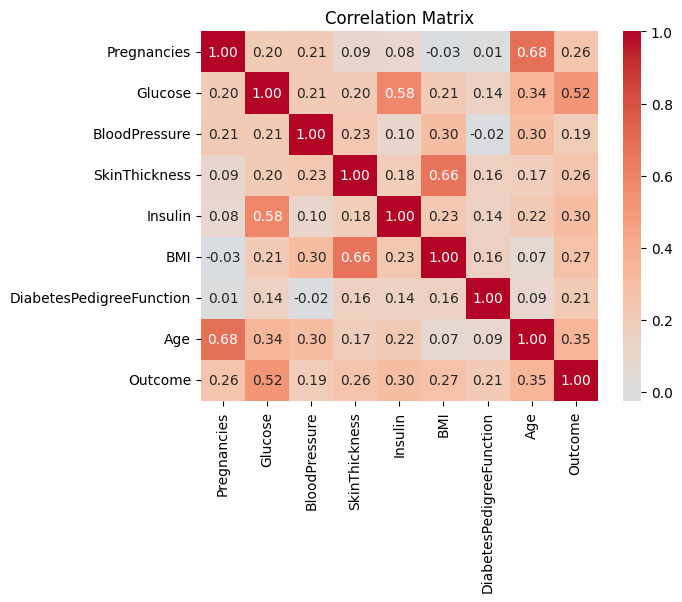

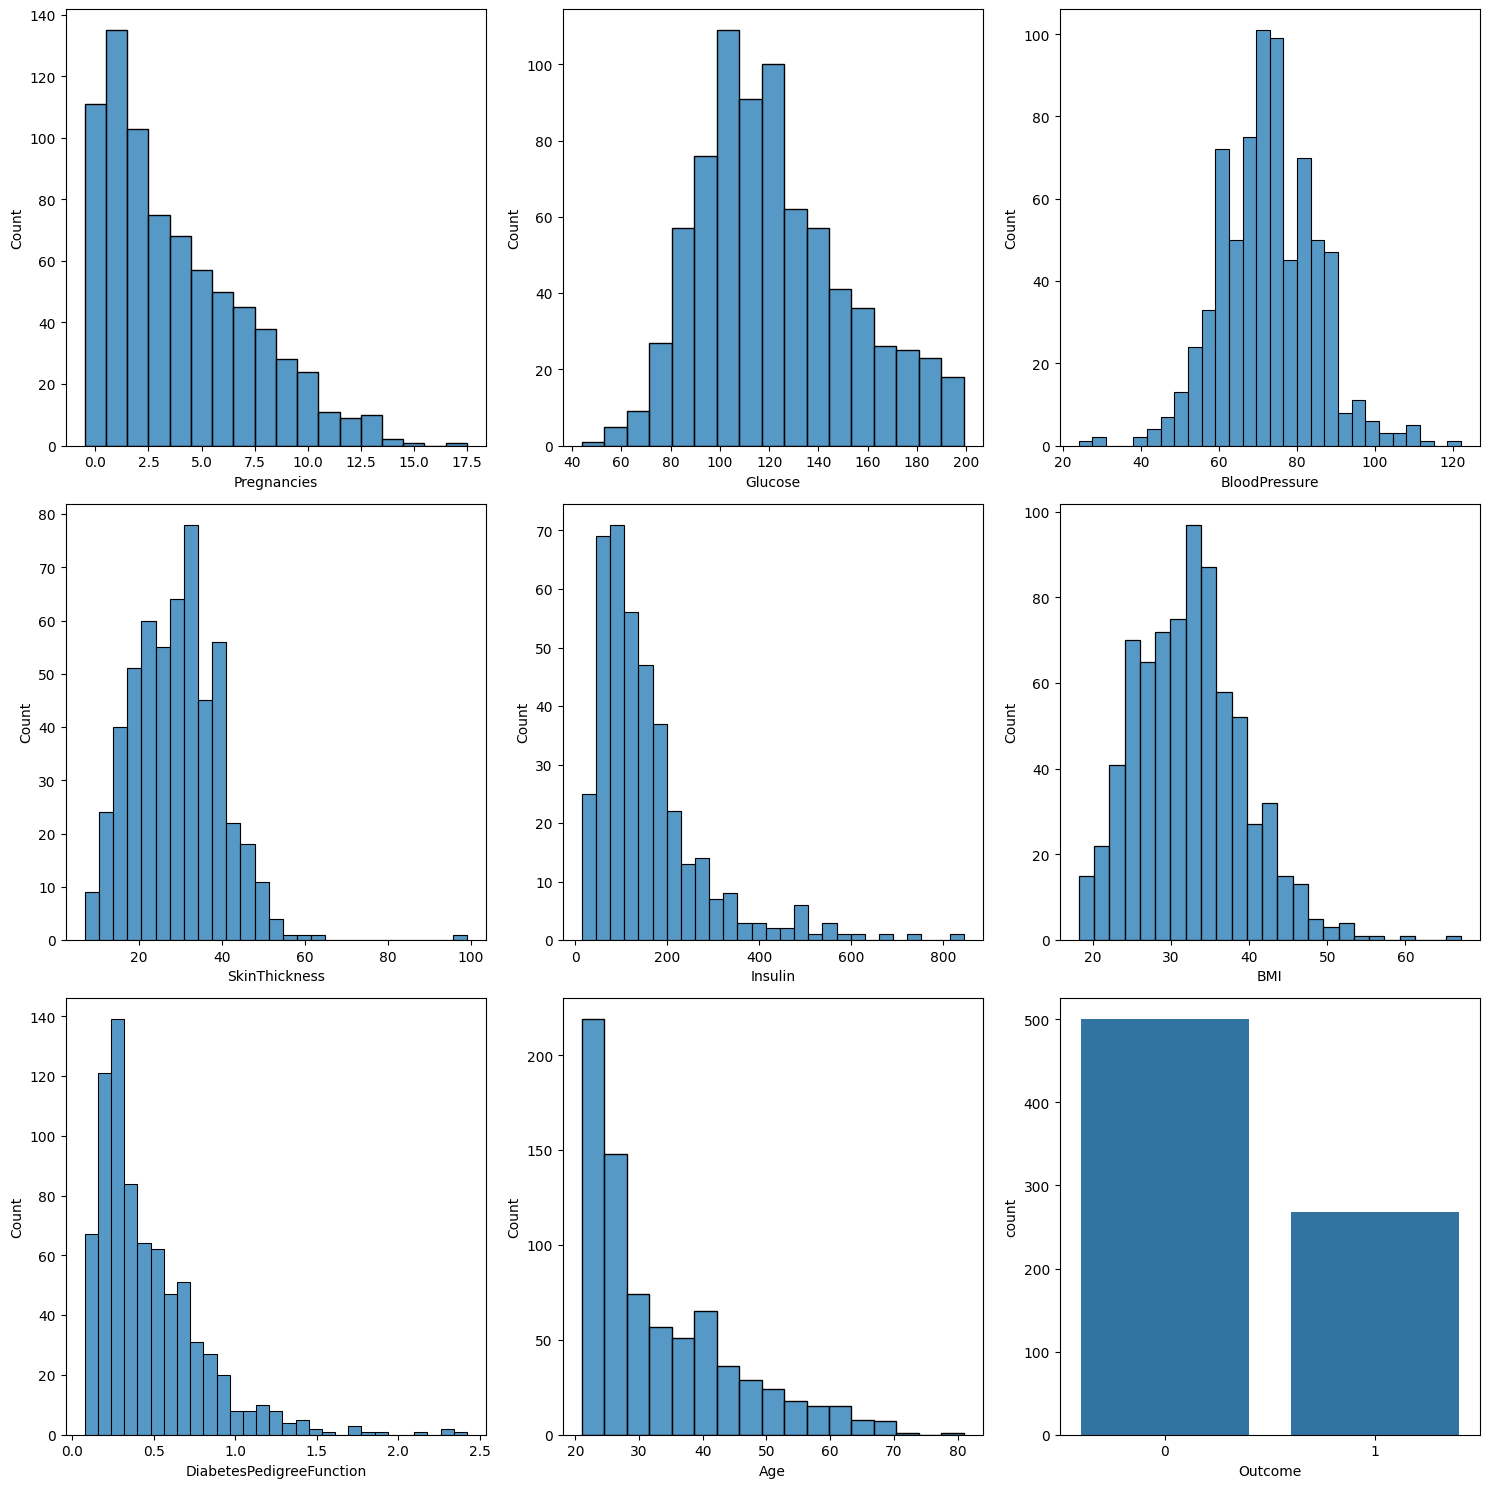

In [18]:
full_dataset = raw_dataset.copy()

non_null_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
full_dataset[non_null_columns] = full_dataset[non_null_columns].replace(0, np.nan)

correlation_matrix = full_dataset.dropna().corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", center=0, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
sns.histplot(full_dataset["Pregnancies"].dropna(), ax=axes[0, 0], discrete=True)
sns.histplot(full_dataset["Glucose"].dropna(), ax=axes[0, 1])
sns.histplot(full_dataset["BloodPressure"].dropna(), ax=axes[0, 2])
sns.histplot(full_dataset["SkinThickness"].dropna(), ax=axes[1, 0])
sns.histplot(full_dataset["Insulin"].dropna(), ax=axes[1, 1])
sns.histplot(full_dataset["BMI"].dropna(), ax=axes[1, 2])
sns.histplot(full_dataset["DiabetesPedigreeFunction"].dropna(), ax=axes[2, 0])
sns.histplot(full_dataset["Age"].dropna(), ax=axes[2, 1])
sns.countplot(data=full_dataset, x="Outcome", ax=axes[2, 2])
plt.tight_layout()
plt.show()

On peut identifier certaines variables fortement corrélées:
- Age - Pregnencies
- BMI - SkinThickness
- Insulin - Glucose
- Glucose - Outcome

### Discrétisation des données

In [19]:
def bin_column(data, column_name, num_bins):
    _, generated_bins = pd.qcut(data[column_name], num_bins, retbins=True)
    generated_bins = np.unique(generated_bins)
    generated_bins[0], generated_bins[-1] = -np.inf, np.inf
    data[column_name] = pd.cut(data[column_name], bins=generated_bins)

binned_dataset = full_dataset.copy()
bin_column(binned_dataset, "Glucose", 5)
bin_column(binned_dataset, "BloodPressure", 2)
bin_column(binned_dataset, "SkinThickness", 3)
bin_column(binned_dataset, "Insulin", 4)
bin_column(binned_dataset, "BMI", 3)
bin_column(binned_dataset, "DiabetesPedigreeFunction", 2)
bin_column(binned_dataset, "Age", 4)
bin_column(binned_dataset, "Pregnancies", 3)

# Création du réseau Bayesien

### Implementation du réseau

In [20]:
class BayesianNetwork:
    class _BayesianNode:
        def __init__(self, name):
            self.name = name
            self.parents = []
            self.children = []
            self.probabilities = None

        def add_child(self, child_node):
            if child_node == self:
                raise ValueError(f"Node {self.name} cannot be its own child")
            if child_node in self.parents:
                raise ValueError(f"Node {child_node.name} is already a parent of {self.name}")
            if child_node in self.children:
                raise ValueError(f"Node {child_node.name} is already a child of {self.name}")
            self.children.append(child_node)
            child_node.parents.append(self)

        # Simple frequencialistic estimation of the conditional probabilities
        # Alpha is the smoothing parameter
        # (Laplace smoothing which is a special case of Dirichlet prior)
        def estimate_probabilities(self, data, alpha=1):
            if not self.parents:
                data_series = data[self.name].dropna()
                self.probabilities = data_series.value_counts(normalize=True)
            else:
                parent_columns = [parent.name for parent in self.parents]
                data_subset = data[parent_columns + [self.name]].dropna()

                grouped = data_subset.groupby(parent_columns + [self.name], observed=False).size()
                if alpha != 0:
                    grouped += alpha
                else:
                    # if alpha == 0, we add 1 to every 0 entries to avoid division by zero
                    grouped[grouped == 0] += 1
                unstacked = grouped.unstack(fill_value=0)
                self.probabilities = unstacked.div(unstacked.sum(axis=1), axis=0).stack()

    def __init__(self):
        self.nodes = []
        self.root_nodes = []

    def add_node(self, name, **kargs):
        new_node = BayesianNetwork._BayesianNode(name, **kargs)
        self.nodes.append(new_node)
        self.root_nodes.append(new_node)
    
    def add_edge(self, parent_node_name, child_node_name):
        parent_node = next((node for node in self.nodes if node.name == parent_node_name), None)
        if parent_node is None:
            raise ValueError(f"Parent node '{parent_node_name}' not found in the network")
        child_node = next((node for node in self.nodes if node.name == child_node_name), None)
        if child_node is None:
            raise ValueError(f"Child node '{child_node_name}' not found in the network")
        if child_node in self.root_nodes:
            self.root_nodes.remove(child_node)
        parent_node.add_child(child_node)

    def estimate_probabilities(self, data, alpha=1):
        if alpha < 0:
            raise ValueError("Alpha must be non-negative")
        if data is None:
            raise ValueError("Data cannot be None")
        
        for node in self.nodes:
            node.estimate_probabilities(data, alpha)

### Définition de la structure du réseau

On choisit dans un premier temps pour expérimenter un "Tree-Augmented Bayesian Network" avec une structure intuitivement cohérente.

In [21]:
network = BayesianNetwork()

network.add_node("Age")
network.add_node("DiabetesPedigreeFunction")
network.add_node("Pregnancies")
network.add_node("BMI")
network.add_node("BloodPressure")
network.add_node("SkinThickness")
network.add_node("Glucose")
network.add_node("Insulin")
network.add_node("Outcome")

network.add_edge("Outcome", "Age")
network.add_edge("Outcome", "DiabetesPedigreeFunction")
network.add_edge("Outcome", "Pregnancies")
network.add_edge("Outcome", "BMI")
network.add_edge("Outcome", "BloodPressure")
network.add_edge("Outcome", "SkinThickness")
network.add_edge("Outcome", "Glucose")
network.add_edge("Outcome", "Insulin")

network.add_edge("Age", "Pregnancies")
network.add_edge("Pregnancies", "Insulin")
network.add_edge("Insulin", "Glucose")
network.add_edge("Insulin", "BMI")
network.add_edge("BMI", "BloodPressure")
network.add_edge("BMI", "SkinThickness")

network.estimate_probabilities(binned_dataset, alpha=0)

### Visualisation du réseau

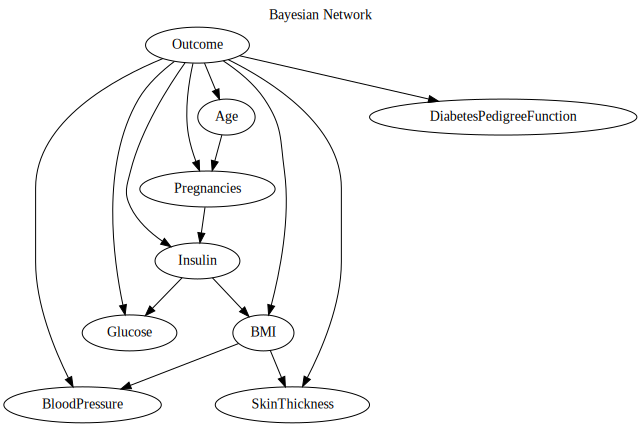

In [22]:
def draw_bayesian_network(dot, bn):
    drawn = set()
    def draw_node(dot, node):
        if node.name in drawn:
            return
        drawn.add(node.name)
        dot.node(node.name, label=node.name)
        for child in node.children:
            draw_node(dot, child)
            dot.edge(node.name, child.name)

    drawn.clear()
    for node in bn.root_nodes:
        draw_node(dot, node)

dot = graphviz.Digraph()
dot.attr(label="Bayesian Network")
dot.attr(labelloc="t")
draw_bayesian_network(dot, network)
dot

# Inférence

La première méthode est une méthode stochastique appelée "Likelihood Weighting"

In [23]:
def inference_likelihood_weighting(network, target_node_name, evidence):
    target_node = next((node for node in network.nodes if node.name == target_node_name), None)
    if target_node is None:
        raise ValueError(f"Target node '{target_node_name}' not found in the network")

    counts = {}
    for value in target_node.probabilities.index.levels[-1]:
        counts[value] = 0
    
    total_counts = 0
    for _ in range(10000):
        likelihood = 1
        values = {}
        for node in network.nodes:
            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            if node.name in evidence:
                values[node.name] = evidence[node.name]
                likelihood *= probabilities[evidence[node.name]]
            else:
                values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)

        total_counts += likelihood
        counts[values[target_node.name]] += likelihood
    
    # Normalize the counts
    for key in counts:
        counts[key] = float(counts[key] / total_counts) if total_counts > 0 else 0
    return counts


La seconde méthode est une méthode de Monté Carlo par chaine de Markov appelée "Gibbs Sampling"

In [24]:
def inference_gibbs_sampling(network, target_node, evidence):
    burn_in = 1000
    sample_size = 5000

    # Initialize counts and total counts for target node
    target_node = next(node for node in network.nodes if node.name == target_node)
    
    values = {}
    for node in network.nodes:
        if node.name in evidence:
            values[node.name] = evidence[node.name]
        else:
            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)

    target_node_values = {}
    for value in target_node.probabilities.index.levels[-1]:
        target_node_values[value] = 0
    for i in range(sample_size):
        for node in network.nodes:
            if node.name in evidence:
                continue

            if not node.parents:
                probabilities = node.probabilities
            else:
                parent_values = tuple(values[parent.name] for parent in node.parents)
                probabilities = node.probabilities.xs(parent_values, level=list(range(len(parent_values))))
            
            for child in node.children:
                if len(child.parents) > 1:
                    child_parent_values = tuple((i, values[parent.name]) for i, parent in enumerate(child.parents) if parent != node)
                    levels, child_parent_values = zip(*child_parent_values)
                    child_probabilities = child.probabilities.xs(child_parent_values, level=levels)
                else:
                    child_probabilities = child.probabilities
                idx = pd.IndexSlice
                probabilities *= child_probabilities[idx[:, values[child.name]]]

            probabilities /= probabilities.sum()
            values[node.name] = np.random.choice(probabilities.index, p=probabilities.values)
        
        if i >= burn_in:
            target_node_values[values[target_node.name]] += 1

    effective_sample_size = sample_size - burn_in
    for key in target_node_values:
        target_node_values[key] /= effective_sample_size
    return target_node_values

La troisième méthode est une méthode d'inférence exacte appelée "Variable Elimination".

In [25]:
def inference_variable_elimination(network, target_node, evidences):
    nodes = network.nodes

    # Step one: create the factors
    factors = [node.probabilities for node in nodes]

    # Step two: restrict the evidence variables
    for evidence_node, e in evidences.items():
        for i in range(len(factors)):
            f = factors[i]
            if evidence_node in f.index.names:
                if isinstance(f.index, pd.MultiIndex):
                    factors[i] = f.xs((e,), level=(evidence_node,))
                else:
                    factors[i] = pd.Series(f[e])

    # Step three: multiply factors and sum out the hidden variables
    hidden_variables = [node.name for node in nodes if node.name not in evidences and node.name != target_node]
    for v in hidden_variables:
        # Multiply all factors that contain the variable
        to_multiply = [(i, f) for i, f in enumerate(factors) if v in f.index.names]
        new_factor = None
        for _, f in to_multiply:
            if new_factor is None:
                new_factor = f
            else:
                new_factor = new_factor * f

        # Remove the factors that were multiplied
        # (reverese the order to avoid index issues)
        for i, _ in reversed(to_multiply):
            factors.pop(i)

        # Sum out the variable
        if (isinstance(new_factor.index, pd.MultiIndex)):
            group = [name for name in new_factor.index.names if name != v]
            new_factor = new_factor.groupby(level=group, observed=False).sum()
            factors.append(new_factor)

    # Step four: multiply the remaining factors
    final_factor = None
    for f in factors:
        if f.size == 1:
            continue
        if final_factor is None:
            final_factor = f
        else:
            final_factor = final_factor * f
    
    # Step five: normalize the final factor
    final_factor = final_factor / final_factor.sum()

    return final_factor

# Evalution du modèle

Best threshold estimation: 0.316 | Specificity: 0.742	Sensitivity: 0.743


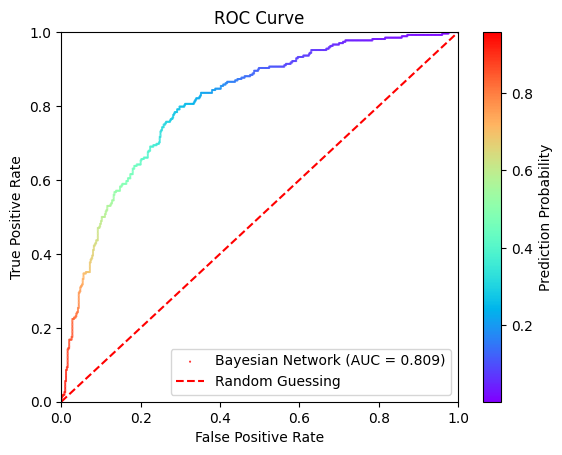

Training with arguments {'alpha': 0, 'threshold': np.float64(0.316020807627432)}


,Predicted Positive,Predicted Negative
Actual Positive,19.5,7.3
Actual Negative,12.5,37.5


Precision: 0.609	Accuracy: 0.742
Recall:    0.728	F1 Score: 0.663


In [32]:
def train_full_cross_split(alpha=0, threshold=0.5, fold=10):
    shuffled_training_dataset = binned_dataset.sample(frac=1)
    split_training_dataset = [shuffled_training_dataset.iloc[i * len(binned_dataset) // fold:(i+1) * len(binned_dataset) // fold, :] for i in range(0, fold)]
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(fold):
        train_data = pd.concat(split_training_dataset[:i] + split_training_dataset[i+1:])
        test_data = split_training_dataset[i]
        network.estimate_probabilities(train_data, alpha=alpha)
        for _, row in test_data.iterrows():
            evidence = {col: row[col] for col in row.index if col != "Outcome" and not pd.isna(row[col])}
            result = inference_variable_elimination(network, "Outcome", evidence)
            expected = row["Outcome"]
            prob = result[1]
            if prob >= threshold and expected == 1:
                tp += 1
            elif prob < threshold and expected == 0:
                tn += 1
            elif prob >= threshold and expected == 0:
                fp += 1
            else:
                fn += 1
    return tp/fold, tn/fold, fp/fold, fn/fold

def test_parameters(**kargs):
    print(f"Training with arguments {kargs}")

    tp, tn, fp, fn = train_full_cross_split(**kargs)

    display(pd.DataFrame({
        "Predicted Positive": [tp, fp],
        "Predicted Negative": [fn, tn]
    }, index=["Actual Positive", "Actual Negative"]))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1_score = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    print(f"Precision: {precision:.3f}\tAccuracy: {accuracy:.3f}")
    print(f"Recall:    {recall:.3f}\tF1 Score: {f1_score:.3f}")

def roc_auc(alpha=0, fold=10):
    actual = []
    predicted_probs = []

    shuffled_training_dataset = binned_dataset.sample(frac=1)
    split_training_dataset = [shuffled_training_dataset.iloc[i * len(binned_dataset) // fold:(i+1) * len(binned_dataset) // fold, :] for i in range(0, fold)]
    tp, fp = 0, 0
    for i in range(fold):
        train_data = pd.concat(split_training_dataset[:i] + split_training_dataset[i+1:])
        test_data = split_training_dataset[i]
        network.estimate_probabilities(train_data, alpha=alpha)
        for _, row in test_data.iterrows():
            evidence = {col: row[col] for col in row.index if col != "Outcome" and not pd.isna(row[col])}
            prob = inference_variable_elimination(network, "Outcome", evidence)
            actual.append(row["Outcome"])
            predicted_probs.append(prob[1])

    total_pos = sum(actual)
    total_neg = len(actual) - total_pos

    sorted_pairs = sorted(zip(predicted_probs, actual), reverse=True)
    points = []

    auc = 0
    prev_tp, prev_fp = 0, 0
    tp, fp = 0, 0
    for prob, actual in sorted_pairs:
        if actual == 1:
            tp += 1
        else:
            fp += 1

        if fp > prev_fp:
            auc += (tp + prev_tp) / (2 * total_pos * total_neg)
        prev_tp, prev_fp = tp, fp

        points.append((fp / total_neg, tp / total_pos, prob))

    return auc, points

auc, points = roc_auc(alpha=0)
for x, y, p in points:
    if 1 - x < y:
        print(f"Best threshold estimation: {p:.3f} | Specificity: {1 - x:.3f}\tSensitivity: {y:.3f}")
        break
x, y, c = zip(*points)
plt.scatter(x, y, s=0.2, c=c, cmap="rainbow", label=f"Bayesian Network (AUC = {auc:.3f})")
plt.colorbar(label="Prediction Probability")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC Curve")
plt.legend()
plt.show()

test_parameters(alpha=0, threshold=p)